In [59]:
import pandas as pd
from tqdm import tqdm
import nltk
import re, string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import pickle


In [2]:
tqdm.pandas()

df = pd.read_csv('data/indonesian-news-title.csv')
df.head()
# Total rows in each category
df['category'].value_counts()

news       32360
hot        16330
finance    14168
travel      6466
inet        5640
health      4919
oto         4383
food        4315
sport       2436
Name: category, dtype: int64

In [3]:
# Get average words in each category
df['word_count'] = df['title'].apply(lambda x: len(x.split()))
df.groupby('category')['word_count'].mean()

category
finance     8.494001
food       10.707068
health      9.733889
hot         9.100796
inet        8.015071
news       10.043850
oto         8.791923
sport       8.158046
travel      8.131457
Name: word_count, dtype: float64

In [4]:
# Get average characters in each category
df['char_count'] = df['title'].apply(lambda x: len(str(x)))
df.groupby('category')['char_count'].mean()

category
finance    54.488354
food       66.314253
health     63.867249
hot        59.409063
inet       52.488830
news       65.721508
oto        57.179101
sport      54.797619
travel     53.277761
Name: char_count, dtype: float64

In [5]:
# Is there any duplicated rows?
df[df['title'].duplicated()]

,date,url,title,category,word_count,char_count
1906,04/17/2020,https://finance.detik.com/detiktv/d-4980330/bl...,Blak-blakan Kartu Pra Kerja dan 'Nepotisme' de...,finance,9,62
3299,04/20/2020,https://finance.detik.com/detiktv/d-4983283/me...,Menteri Perdagangan Buka Kartu Stok Sembako Sa...,finance,8,55
3732,03/09/2020,https://finance.detik.com/market-research/d-49...,IHSG Diperkirakan Melemah di Awal Pekan,finance,6,39
5613,03/11/2020,https://finance.detik.com/berita-ekonomi-bisni...,Harga Emas Antam Turun Rp 3.000,finance,6,31
5779,01/22/2020,https://finance.detik.com/fintech/d-4868943/lo...,Lokasi Kantor Jadi Syarat Pinjol Dapat Izin OJK,finance,8,47
...,...,...,...,...,...,...
89764,01/18/2020,https://travel.detik.com/fototravel/d-4864101/...,Aksi Para Penunggang Kuda Menerobos Kobaran Ap...,travel,9,58
89932,04/03/2020,https://travel.detik.com/travel-news/d-4963492...,Rasakan Kenyamanan Work From Hotel di Fraser R...,travel,9,62
90206,06/03/2020,https://travel.detik.com/travel-news/d-5039514...,"New Normal, VW Cabrio Borobudur Siap Sambut Wi...",travel,8,53
90444,04/14/2020,https://travel.detik.com/fototravel/d-4977157/...,5 Negara yang Diprediksi Paling Cepat Bangkit ...,travel,9,57


In [6]:
# Tokenizing
nltk.download('punkt')
# Stopwords removal
nltk.download('stopwords')
# Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

print('Completed')

Completed


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ottot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ottot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ottot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ottot\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
# Dellete "news" and "hot" category to remove any overlapping category
df.drop(df[df.category == 'news'].index, inplace=True)
df.drop(df[df.category == 'hot'].index, inplace=True)

# See category stats
df['category'].value_counts

<bound method IndexOpsMixin.value_counts of 0        finance
1        finance
2        finance
3        finance
4        finance
          ...   
91012     travel
91013     travel
91014     travel
91015     travel
91016     travel
Name: category, Length: 42327, dtype: object>

In [8]:
df.drop(df[df['title'].duplicated()].index, inplace=True)
df['title']

0                           Kemnaker Awasi TKA di Meikarta
1                        BNI Digitalkan BNI Java Jazz 2020
2        Terbang ke Australia, Edhy Prabowo Mau Genjot ...
3        OJK Siapkan Stimulus Ekonomi Antisipasi Dampak...
4        Saran Buat Anies-RK yang Mangkir Rapat Banjir ...
                               ...                        
91012    Ketumpahan Air Panas di Pesawat, Kamu Bisa Tun...
91013    Foto: Bali & 9 Destinasi Paling Instagramable ...
91014    Game Bikin Turis Ini Liburan ke Jepang untuk.....
91015    Sekeluarga Didepak dari Pesawat, Maskapai Bila...
91016    Kapal Raib di Segitiga Bermuda, Nyaris Seabad ...
Name: title, Length: 42264, dtype: object

In [9]:

# Cleaning
def cleaning(text):
  # Case folding
  text = text.lower() 
  # Trim text
  text = text.strip()
  # Remove punctuations, special characters, and double whitespace
  text = re.compile('<.*?>').sub('', text) 
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
  text = re.sub('\s+', ' ', text)
  # Number removal
  text = re.sub(r'\[[0-9]*\]', ' ', text) 
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
  # Remove number and whitespaces
  text = re.sub(r'\d', ' ', text)
  text = re.sub(r'\s+', ' ', text)

  return text

df['title'] = df['title'].apply(lambda x: cleaning(x))
df['title']

0                           kemnaker awasi tka di meikarta
1                            bni digitalkan bni java jazz 
2        terbang ke australia edhy prabowo mau genjot b...
3        ojk siapkan stimulus ekonomi antisipasi dampak...
4        saran buat anies rk yang mangkir rapat banjir ...
                               ...                        
91012    ketumpahan air panas di pesawat kamu bisa tunt...
91013      foto bali destinasi paling instagramable tahun 
91014    game bikin turis ini liburan ke jepang untuk c...
91015    sekeluarga didepak dari pesawat maskapai bilan...
91016    kapal raib di segitiga bermuda nyaris seabad b...
Name: title, Length: 42264, dtype: object

In [10]:
df['tokens'] = df['title'].apply(lambda x: word_tokenize(x))
df['tokens']

0                     [kemnaker, awasi, tka, di, meikarta]
1                       [bni, digitalkan, bni, java, jazz]
2        [terbang, ke, australia, edhy, prabowo, mau, g...
3        [ojk, siapkan, stimulus, ekonomi, antisipasi, ...
4        [saran, buat, anies, rk, yang, mangkir, rapat,...
                               ...                        
91012    [ketumpahan, air, panas, di, pesawat, kamu, bi...
91013    [foto, bali, destinasi, paling, instagramable,...
91014    [game, bikin, turis, ini, liburan, ke, jepang,...
91015    [sekeluarga, didepak, dari, pesawat, maskapai,...
91016    [kapal, raib, di, segitiga, bermuda, nyaris, s...
Name: tokens, Length: 42264, dtype: object

In [11]:
stop_words = set(chain(stopwords.words('indonesian'), stopwords.words('english')))

df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

0                         [kemnaker, awasi, tka, meikarta]
1                       [bni, digitalkan, bni, java, jazz]
2        [terbang, australia, edhy, prabowo, genjot, bu...
3        [ojk, siapkan, stimulus, ekonomi, antisipasi, ...
4          [saran, anies, rk, mangkir, rapat, banjir, dpr]
                               ...                        
91012    [ketumpahan, air, panas, pesawat, tuntut, mask...
91013               [foto, bali, destinasi, instagramable]
91014    [game, bikin, turis, liburan, jepang, cari, ya...
91015    [sekeluarga, didepak, pesawat, maskapai, bilan...
91016     [kapal, raib, segitiga, bermuda, seabad, ketemu]
Name: tokens, Length: 42264, dtype: object

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()
 
df['tokens'] = df['tokens'].progress_apply(lambda x: stemmer.stem(' '.join(x)).split(' '))
df['tokens']

In [61]:

df['tokens'] = np.load('tokenized.npy',allow_pickle=True)
df['joined_tokens'] = df['tokens'].apply(lambda x: ' '.join(x))
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['joined_tokens'].values)

X = tokenizer.texts_to_sequences(df['joined_tokens'].values)
X = pad_sequences(X, maxlen=max_len)
Y = pd.get_dummies(df['category']).values

In [78]:
import pandas as pd
label = pd.Series(df['category']).unique()
print(label)

['finance' 'food' 'health' 'inet' 'oto' 'sport' 'travel']


In [62]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [63]:
print(Y)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [66]:
# Inisiliasi max feature dan max_length
max_features = 2000
max_len = 200


AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [68]:
# Buat Model LSTM
model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(LSTM(64 , dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))

In [69]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
463/463 [==============================] - 88s 190ms/step - loss: 0.8582 - accuracy: 0.7066 - val_loss: 0.5280 - val_accuracy: 0.8252
Epoch 2/10
463/463 [==============================] - 91s 197ms/step - loss: 0.4713 - accuracy: 0.8461 - val_loss: 0.4901 - val_accuracy: 0.8379
Epoch 3/10
463/463 [==============================] - 88s 189ms/step - loss: 0.4060 - accuracy: 0.8654 - val_loss: 0.4832 - val_accuracy: 0.8397
Epoch 4/10
463/463 [==============================] - 92s 198ms/step - loss: 0.3710 - accuracy: 0.8734 - val_loss: 0.4814 - val_accuracy: 0.8392
Epoch 5/10
463/463 [==============================] - 89s 192ms/step - loss: 0.3467 - accuracy: 0.8801 - val_loss: 0.4916 - val_accuracy: 0.8394
Epoch 6/10
463/463 [==============================] - 90s 194ms/step - loss: 0.3276 - accuracy: 0.8884 - val_loss: 0.4968 - val_accuracy: 0.8380
Epoch 7/10
463/463 [==============================] - 99s 215ms/step - loss: 0.3130 - accuracy: 0.8929 - val_loss: 0.5180 - val_ac

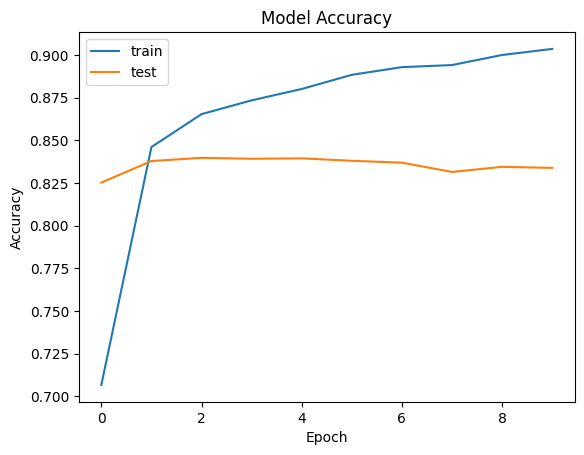

In [72]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_new.png')
plt.show()



In [74]:
# predict on test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

# calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

397/397 [==============================] - 7s 18ms/step
Accuracy: 0.8152996845425867
Precision: 0.8578541199900424
Recall: 0.8152996845425867
F-1 Score: 0.8360357446120255


In [75]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\embedding
......vars
.........0
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-27 12:56:09         2217
metadata.json                                  2023-03-27 12:56:09           64
variables.h5                                   2023-03-27 12:56:09      1962384
